## DQNでエージェントを構築

In [25]:
import os
import random
from typing import *
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import copy
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchinfo

import ipytest
ipytest.autoconfig()

## オセロ環境

In [26]:
def opponent(c):
    """現在のプレイヤーの相手を返す"""
    return -c

EMPTY, BLACK, WHITE = 0, 1, -1
DIRECTIONS = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]

class Othello:
    def __init__(self):
        self.board = [[EMPTY for _ in range(8)] for _ in range(8)]
        self.board[3][3] = self.board[4][4] = WHITE
        self.board[3][4] = self.board[4][3] = BLACK
        self.player = BLACK

    def clone(self):
        """盤面をコピーして新しいインスタンスを返す"""
        g = Othello()
        g.board = [row[:] for row in self.board]
        g.player = self.player
        return g

    def inside(self, r, c):
        """
        盤面の範囲内かを返す
        Args:
            r (int): 行
            c (int): 列
        Returns:
            bool: 盤面の範囲内か
        """
        return 0 <= r < 8 and 0 <= c < 8

    def legal_moves(self, player=None) -> List[Tuple[int, int]]:
        """
        合法手を返す
        Args:
            player (int, optional): プレイヤーの色.指定しない場合は現在のプレイヤーを返す
        Returns:
            List[Tuple[int, int]]: 合法手のリスト
        """
        if player is None:
            player = self.player
        moves = []
        for r in range(8):
            for c in range(8):
                if self.board[r][c] != EMPTY:  # 空白でない場合は合法手ではない
                    continue
                if self._would_flip(r, c, player):  # 石をひっくり返せる場合は合法手
                    moves.append((r, c))
        return moves

    def _would_flip(self, r, c, player) -> bool:
        """
        石をひっくり返せるかを返す
        Args:
            r (int): 行
            c (int): 列
            player (int): プレイヤーの色
        Returns:
            bool: 石をひっくり返せるか
        """
        if self.board[r][c] != EMPTY:  # 空白でない場合は石をひっくり返せない
            return False
        for dr, dc in DIRECTIONS:
            rr, cc = r + dr, c + dc
            seen_opp = False  # 相手の石を一度見たか
            while self.inside(rr, cc) and self.board[rr][cc] == opponent(player):  # 盤面の範囲内か & 相手の石が置かれている場所か
                seen_opp = True
                rr += dr; cc += dc
            if seen_opp and self.inside(rr, cc) and self.board[rr][cc] == player:  # 相手の石を一度見たか & 盤面の範囲内か & 自分の石をみたか
                return True
        return False

    def play(self, r, c, player=None):
        """
        石を置く & 石をひっくり返す
        Args:
            r (int): 行
            c (int): 列
            player (int, optional): プレイヤーの色.指定しない場合は現在のプレイヤーを返す
        """
        if player is None:
            player = self.player
        assert self.board[r][c] == EMPTY  # 空白でない場合は石を置くことができない
        flipped = []
        for dr, dc in DIRECTIONS:
            line = []
            rr, cc = r + dr, c + dc
            while self.inside(rr,cc) and self.board[rr][cc] == opponent(player):  # 盤面の範囲内か & 相手の石が置かれている場所か
                line.append((rr,cc))  # 石をひっくり返す場所を追加
                rr += dr; cc += dc
            if line and self.inside(rr,cc) and self.board[rr][cc] == player:  # 石をひっくり返す場所が存在 & 盤面の範囲内か & 自分の石をみたか
                flipped.extend(line)  # 石をひっくり返す場所を追加
        if not flipped:  # 石をひっくり返す場所が存在しない場合は不正な手
            raise ValueError("Illegal move")
        self.board[r][c] = player
        for rr,cc in flipped:  # 石をひっくり返す
            self.board[rr][cc] = player
        self.player = opponent(player)
        # 現在のプレイヤーが合法手がない場合は相手の番
        if not self.legal_moves(self.player):
            self.player = opponent(self.player)

    def is_terminal(self) -> bool:
        """
        終局かを返す
        Returns:
            bool: 終局か
        """
        if self.legal_moves(BLACK): return False
        if self.legal_moves(WHITE): return False
        return True

    def game_score(self) -> int:
        """
        黒が+1, 白が-1としてスコアを計算
        Returns:
            int: スコア
        """
        s = 0
        for r in range(8):
            for c in range(8):
                s += self.board[r][c]
        return s

    def winner(self) -> int:
        s = self.game_score()
        return BLACK if s > 0 else WHITE if s < 0 else 0

### 報酬設計

In [27]:
class Reward:
    def __init__(
        self, player,
        weight_corner=1.0, weight_dangerous=-1.2,
        weight_mobility=1.0, weight_frontier=-0.6
    ):
        """
        Args:
            player (int): 手番
            weight_corner (float): 角の重み
            weight_dangerous (float): 危険な場所の重み
            weight_mobility (float): モビリティの重み
            weight_frontier (float): フロンティアの重み
        """
        self.player = player
        self.weight_corner = weight_corner
        self.weight_dangerous = weight_dangerous
        self.weight_mobility = weight_mobility
        self.weight_frontier = weight_frontier

    def get_reward(self, env: Othello):
        """
        Args:
            env (Othello): オセロ環境
        Returns:
            float: 報酬
        """
        if self._is_terminal(env):
            pc, oc = self._count_stones(env)
            # 勝敗ベースの終局報酬
            return 1.0 if pc > oc else (-1.0 if pc < oc else 0.0)

        phase = self._get_game_phase(env)

        # 角
        my_corner, op_corner = self._count_corner_stones(env)
        corner_term = self._safe_ratio(my_corner - op_corner, max(1, my_corner + op_corner))

        # 危険（X/C だけを見る）
        my_dang, op_dang = self._count_xc_danger(env)
        danger_term = self._safe_ratio(my_dang - op_dang, max(1, my_dang + op_dang))

        # モビリティ（相対値）
        my_mob = len(env.legal_moves(self.player))
        op_mob = len(env.legal_moves(opponent(self.player)))
        mobility_term = self._safe_ratio(my_mob - op_mob, max(1, my_mob + op_mob))

        # フロンティア（多いほど悪い → 符号反転）
        my_front, op_front = self._count_frontier(env)
        frontier_term = self._safe_ratio(my_front - op_front, max(1, my_front + op_front))

        if phase in (0, 1):  # 序・中盤
            reward = (
                self.weight_mobility * mobility_term +
                self.weight_corner   * corner_term +
                self.weight_dangerous * danger_term +
                self.weight_frontier * frontier_term
            )
        else:  # 後盤（石差を薄く採用）
            pc, oc = self._count_stones(env)
            disc_diff_term = self._safe_ratio(pc - oc, max(1, pc + oc))
            reward = 0.5 * (self.weight_corner * corner_term) \
                   + 0.3 * (self.weight_mobility * mobility_term) \
                   + 0.2 * disc_diff_term

        # クリップ
        return max(-1.0, min(1.0, reward))

    # ---------- 補助 ----------
    def _is_terminal(self, env: Othello):
        return (len(env.legal_moves(self.player)) == 0 and
                len(env.legal_moves(opponent(self.player))) == 0)

    def _safe_ratio(self, num, den):  # [-1,1] 目安
        return num / den if den != 0 else 0.0

    def _get_game_phase(self, env: Othello):
        pc, oc = self._count_stones(env)
        n = pc + oc
        if n <= 20:  # 序盤
            return 0
        elif n <= 45:  # 中盤
            return 1
        else:  # 後盤
            return 2

    def _count_stones(self, env: Othello):
        pc = oc = 0
        for r in range(8):
            for c in range(8):
                if env.board[r][c] == self.player: pc += 1
                elif env.board[r][c] == opponent(self.player): oc += 1
        return pc, oc

    def _count_corner_stones(self, env: Othello):
        corners = [(0,0),(0,7),(7,0),(7,7)]
        pc = oc = 0
        for r,c in corners:
            if env.board[r][c] == self.player: pc += 1
            elif env.board[r][c] == opponent(self.player): oc += 1
        return pc, oc

    def _count_xc_danger(self, env: Othello):
        # 角と対応する X/C だけを見る
        corners = [(0,0),(0,7),(7,0),(7,7)]
        X      = [(1,1),(1,6),(6,1),(6,6)]
        C      = [(0,1),(1,0),(0,6),(1,7),(6,0),(7,1),(6,7),(7,6)]
        pc = oc = 0
        # X
        for (xr,xc),(cr,cc) in zip(X,corners):
            if env.board[cr][cc] == EMPTY:
                if env.board[xr][xc] == self.player: pc += 1
                elif env.board[xr][xc] == opponent(self.player): oc += 1
        # C（対応角が空なら危険）
        for r,c in C:
            cr = 0 if r in (0,1) else 7
            cc = 0 if c in (0,1) else 7
            if env.board[cr][cc] == EMPTY:
                if env.board[r][c] == self.player: pc += 1
                elif env.board[r][c] == opponent(self.player): oc += 1
        return pc, oc

    def _count_frontier(self, env: Othello):
        pc = oc = 0
        for r in range(8):
            for c in range(8):
                cell = env.board[r][c]
                if cell == EMPTY:
                    continue
                # 隣に空きがあればフロンティア
                frontier = any(
                    0 <= r+dr < 8 and 0 <= c+dc < 8 and env.board[r+dr][c+dc] == EMPTY
                    for dr in (-1,0,1) for dc in (-1,0,1) if dr or dc
                )
                if frontier:
                    if cell == self.player: pc += 1
                    elif cell == opponent(self.player): oc += 1
        return pc, oc

### テスト

In [28]:
%%ipytest -qq


# オセロクラスの簡単な初期化テスト
def test_othello_init():
    env = Othello()

    # ボードのサイズ
    assert len(env.board) == 8
    assert all(len(row) == 8 for row in env.board)

    # 中心マスの初期配置
    assert env.board[3][3] == -1
    assert env.board[3][4] == 1
    assert env.board[4][3] == 1
    assert env.board[4][4] == -1

    # 中心ます以外は0
    for i in range(8):
        for j in range(8):
            if i == 3 and j in (3, 4):
                continue
            if i == 4 and j in (3, 4):
                continue
            assert env.board[i][j] == 0

    # 初手は黒（1）の番
    assert env.player == 1

.                                                                                            [100%]


In [29]:
%%ipytest -qq

BLACK = 1
WHITE = -1

# Rewardクラスのテスト
class TestReward:
    def setup_method(self):
        self.env = Othello()
        self.reward_black = Reward(BLACK)
        self.reward_white = Reward(WHITE)

    def test_init(self):
        assert self.reward_black.player == BLACK
        assert self.reward_white.player == WHITE

    def test_terminal_black_win(self):
        env = Othello()
        env.board = [[BLACK] * 8 for _ in range(8)]

        assert self.reward_black.get_reward(env) == 1
        assert self.reward_white.get_reward(env) == -1

    def test_terminal_draw(self):
        env = Othello()
        env.board = [[BLACK if (i + j) % 2 else WHITE for j in range(8)] for i in range(8)]

        assert self.reward_black.get_reward(env) == 0
        assert self.reward_white.get_reward(env) == 0

    def test_early_phase(self):
        env = Othello()

        # 序盤かを確認
        assert self.reward_black._get_game_phase(env) == 0

        # 初期配置パターンでの報酬を確認
        reward_black = self.reward_black.get_reward(env)
        reward_white = self.reward_white.get_reward(env)
        assert abs(reward_black) < 1e-5
        assert abs(reward_white) < 1e-5

....                                                                                         [100%]


## DQNのネットワーク定義

In [30]:
class DSConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.dw = nn.Conv2d(
            in_channels=in_channels, out_channels=in_channels,
            kernel_size=3, padding=1, groups=in_channels, bias=False,
        )
        self.pw = nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=1, bias=False,
        )
        self.gn = nn.GroupNorm(num_groups=1, num_channels=out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        x = self.dw(x)
        x = self.pw(x)
        x = self.gn(x)
        x = self.act(x)
        return x


class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=8,
                kernel_size=3, padding=1, bias=False,
            ),
            nn.SiLU(),
        )
        self.block1 = DSConv(in_channels=8, out_channels=8)
        self.block2 = DSConv(in_channels=8, out_channels=8)

        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8, out_features=64),
            nn.SiLU(),
        )
        self.head = nn.Linear(in_features=64, out_features=65)  # 65番目は、パスの行動

    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.gap(x)
        x = self.fc(x)
        x = self.head(x)
        return x

In [31]:
# アーキテクチャのテスト
dqn = DQN()
dummy_input = torch.zeros((1, 1, 8, 8))
print(dqn(dummy_input).shape)
torchinfo.summary(dqn, (1, 1, 8, 8))

torch.Size([1, 65])


Layer (type:depth-idx)                   Output Shape              Param #
DQN                                      [1, 65]                   --
├─Sequential: 1-1                        [1, 8, 8, 8]              --
│    └─Conv2d: 2-1                       [1, 8, 8, 8]              72
│    └─SiLU: 2-2                         [1, 8, 8, 8]              --
├─DSConv: 1-2                            [1, 8, 8, 8]              --
│    └─Conv2d: 2-3                       [1, 8, 8, 8]              72
│    └─Conv2d: 2-4                       [1, 8, 8, 8]              64
│    └─GroupNorm: 2-5                    [1, 8, 8, 8]              16
│    └─SiLU: 2-6                         [1, 8, 8, 8]              --
├─DSConv: 1-3                            [1, 8, 8, 8]              --
│    └─Conv2d: 2-7                       [1, 8, 8, 8]              72
│    └─Conv2d: 2-8                       [1, 8, 8, 8]              64
│    └─GroupNorm: 2-9                    [1, 8, 8, 8]              16
│    └─SiLU: 2-

## DQNの学習

In [32]:
class ReplayBuffer:
    def __init__(self, memory_size):
        self.memory_size = memory_size
        self.memory = deque(maxlen=memory_size)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

In [33]:
class TrainDQN:
    """
    DQNを訓練するクラス
    """
    def __init__(self, dqn: DQN, gamma=0.95, lr=0.001, batch_size=8, init_memory_size=5000, memory_size=5000, target_update_freq=30, num_episodes=1000):
        self.dqn = dqn
        self.target_dqn = copy.deepcopy(dqn)
        self.optimizer = optim.Adam(dqn.parameters(), lr=lr)

        self.gamma = gamma
        self.batch_size = batch_size
        self.init_memory_size = init_memory_size
        self.replay_buffer = ReplayBuffer(memory_size)
        self.target_update_freq = target_update_freq
        self.num_episodes = num_episodes

        self.target_update_count = 0

        self.loss_fn = nn.SmoothL1Loss()

        # 初期リプレイバッファの作成
        self._init_replay_buffer()

        self.rewards = []

    def train(self):
        pbar = tqdm.tqdm(total=self.num_episodes, desc='Train DQN')
        for episode in range(self.num_episodes):
            # １回のパラメータ更新
            loss = self._update_dqn()

            # Rewardクラスを用いて評価
            if episode % 10 == 0:
                reward = self._get_reward(max_steps=100, epsilon=0.0)

            self.rewards.append(reward)

            pbar.set_postfix_str(
                f'Loss: {loss:.3f}, Reward: {self.rewards[-1]:.3f}'
            )
            pbar.update(1)

        pbar.close()

        return self.rewards

    def _select_action_with_model(self, env: Othello, epsilon=0.1):
        """
        現在のDQNを用いて、ε-greedyで行動を選択する
        """
        player = env.player
        legal_rc = env.legal_moves(player)

        # 合法手がない場合はパス
        if len(legal_rc) == 0:
            return 64

        # ε-greedy
        if random.random() < epsilon:
            r, c = random.choice(legal_rc)
            return self._rc_to_action(r, c)
        else:
            return self._select_action_by_greedy(env)

    def _select_action_by_greedy(self, env: Othello):
        """
        現在のDQNを用いて、greedyで行動を選択する
        """
        player = env.player
        legal_rc = env.legal_moves(player)

        board_tensor = self._to_1x8x8(env.board).unsqueeze(0)
        with torch.no_grad():
            q_all = self.dqn(board_tensor).squeeze(0)

            # 合法種以外を、-infにする
            mask = torch.full((65,), float('-inf'))
            for r, c in legal_rc:
                mask[self._rc_to_action(r, c)] = 0.0

            # 合法手がある時は基本的にパスは無効
            q_masked = q_all + mask
            action = q_masked.argmax().item()

        return action

    def _get_reward(self, max_steps, epsilon):
        """
        現在のDQN方策で１エピソードをプレイし、各手で報酬を計算
        Returns:
            float: エピソードの総報酬
        """
        env = Othello()
        total_reward = 0.0
        steps = 0

        # 盤面のコピーは不要 envを直接進めていく
        while not env.is_terminal() and steps < max_steps:
            player = env.player
            action = self._select_action_with_model(env, epsilon)

            if action == 64:
                # パス
                env.player = -player
            else:
                r, c = self._action_to_rc(action)
                env.play(r, c, player)

            steps += 1
            total_reward += float(Reward(player).get_reward(env))

        return total_reward

    def _update_dqn(self):
        """
        1ステップのDQN更新を行う
        - バッファからサンプル
        - target DQNでnext_Qを計算
        - Qネットワークの更新
        Returns:
            float: 損失値
        """
        batch = self.replay_buffer.sample(self.batch_size)

        board = torch.stack([b['board'] for b in batch])
        next_board = torch.stack([b['next_board'] for b in batch])
        action = torch.tensor([b['action'] for b in batch], dtype=torch.int64)
        reward = torch.tensor([b['reward'] for b in batch], dtype=torch.float32)
        done = torch.tensor([b['done'] for b in batch], dtype=torch.float32)

        # 現在のdqnでQ値を計算
        q_sa = self.dqn(board).gather(1, action.unsqueeze(1)).squeeze(1)

        # ターゲットネットで計算
        with torch.no_grad():
            next_q_max = self.target_dqn(next_board).max(1)[0]
            target = reward + self.gamma * next_q_max * (1 - done)

        # 損失と学習
        loss = self.loss_fn(q_sa, target)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.dqn.parameters(), max_norm=1.0)
        self.optimizer.step()

        # target_update_freqごとにtarget_dqnを更新
        self.target_update_count += 1
        if self.target_update_count % self.target_update_freq == 0:
            self.target_dqn.load_state_dict(self.dqn.state_dict())

        return float(loss.item())

    def _action_to_rc(self, action):
        """
        行動番号を行列座標に変換する
        """
        return divmod(int(action), 8)

    def _legal_rc_to_action(self, legal_rc):
        return torch.tensor([self._rc_to_action(r, c) for r, c in legal_rc], dtype=torch.int64)

    def _init_replay_buffer(self):
        """
        ランダムな行動でリプレイバッファを初期化する
        """
        target = min(self.init_memory_size, self.replay_buffer.memory_size)
        added = 0
        pbar = tqdm.tqdm(total=target, desc='Init replay buffer')
        pbar.update(added)

        while added < target:
            # 新規環境でエピソード作成
            env = Othello()
            done = False

            # 状態の初期盤面
            board = copy.deepcopy(env.board)

            while not done and added < target:
                player = env.player
                legal_actions = env.legal_moves(player)

                # ランダム方策
                if len(legal_actions) == 0:
                    # パス
                    action = 64
                    env.player = -player
                    next_board = copy.deepcopy(env.board)
                else:
                    r, c = random.choice(legal_actions)
                    action = self._rc_to_action(r, c)
                    env.play(r, c, player)
                    next_board = copy.deepcopy(env.board)

                # 終局判定
                done = env.is_terminal()

                # 報酬（着手プレイヤー目線）
                reward = self.compute_reward(env, player)

                # 保存
                self._store_transition(board, action, reward, next_board, done)

                # 状態の更新
                board = next_board
                added += 1
                pbar.update(1)

        pbar.close()

    def _rc_to_action(self, row, col):
        """
        行列座標を行動番号に変換する
        """
        return row * 8 + col

    def compute_reward(self, next_env, player):
        """
        次の環境から報酬を計算する
        Args:
            next_env: 次の環境
            player: 現在のプレイヤー
        Returns:
            float: 報酬
        """
        try:
            reward = Reward(player).get_reward(next_env)
        except Exception:
            reward = 0
        return float(reward)

    def _store_transition(self, board, action, reward, next_board, done):
        """
        リプレイバッファに state, action, reward, next_state, doneを格納する
        state、next_stateは 8x8を最終的に1x8x8に正規化
        """
        # stateとnext_stateを1x8x8のtensorに変換
        board = self._to_1x8x8(board)
        next_board = self._to_1x8x8(next_board)

        action = int(action)
        reward = float(reward)
        done = bool(done)

        transition = {
            'board': board,
            'action': action,
            'reward': reward,
            'next_board': next_board,
            'done': done
        }

        self.replay_buffer.append(transition)

    def _to_1x8x8(self, board):
        """
        8x8の配列を1x8x8のtensorに変換する
        """
        if board is None:
            return None

        board = torch.as_tensor(board, dtype=torch.float32)

        # 8x8 -> 1x8x8
        if board.dim() == 2 and board.shape[0] == 8 and board.shape[1] == 8:
            board = board.unsqueeze(0)

        # 1x1x8x8 -> 1x8x8
        elif board.dim() == 4 and board.shape[1] == 1 and board.shape[2] == 8 and board.shape[3] == 8:
            board = board.squeeze(1)

        # すでに1x8x8の場合は変更しない
        elif board.dim() == 3 and board.shape[0] == 1 and board.shape[1] == 8 and board.shape[2] == 8:
            pass

        # 想定外形状の場合は強制的に1x8x8に変換する
        else:
            board = board.reshape(1, 8, 8)[0:1]

        return board



In [34]:
dqn = DQN()
train_dqn = TrainDQN(dqn)
print("init_memory_size =", train_dqn.init_memory_size, "memory_size =", train_dqn.replay_buffer.memory_size)
print("len(memory) before =", len(train_dqn.replay_buffer.memory))

Init replay buffer:   0%|          | 0/5000 [00:00<?, ?it/s]

init_memory_size = 5000 memory_size = 5000
len(memory) before = 5000


In [35]:
memory = train_dqn.replay_buffer.memory
list_done = [m['done'] for m in memory]
print("done count =", list_done.count(True), "/", len(list_done), list_done.count(True) / len(list_done))

done count = 83 / 5000 0.0166


Init replay buffer:   0%|          | 0/5000 [00:00<?, ?it/s]

Train DQN:   0%|          | 0/10000 [00:00<?, ?it/s]

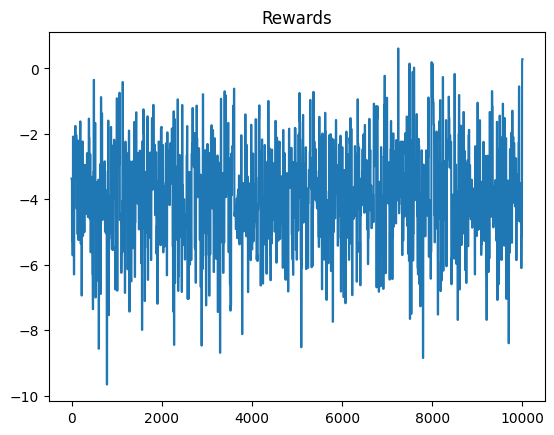

In [36]:
# 学習して、結果（報酬の推移）をプロット
dqn = DQN()
train_dqn = TrainDQN(dqn, num_episodes=10000)
rewards = train_dqn.train()

plt.plot(rewards)
plt.title("Rewards")
plt.show()